In [1]:
print(1)


1


### ML methods

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

In [3]:
def ml_tech(train ,test):
    vectorizer = CountVectorizer()
    vectorizer.fit(train.text.tolist())
    train_features = vectorizer.transform(train.text.tolist())
    test_features = vectorizer.transform(test.text.tolist())
    train_labels = train.sensitivity
    test_labels = test.sensitivity

    dummy_mf = DummyClassifier(strategy="most_frequent")
    dummy_mf.fit(train_features, train_labels)
    mf_preds = dummy_mf.predict(test_features)
    #evaluation_summary("Dummy MF", test_labels, mf_preds)

    dummy_rand = DummyClassifier(strategy="stratified")
    dummy_rand.fit(train_features, train_labels)
    rand_preds = dummy_rand.predict(test_features)
    #evaluation_summary("Dummy Random stratified sampling", test_labels, rand_preds)


    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(train.text.tolist())
    test_tfidf = tfidf_vectoizer.transform(test.text.tolist())

    lr = LogisticRegression(max_iter=500)
    lr.fit(train_tfidf, train.sensitivity)
    lr_preds = lr.predict(test_tfidf)
    #evaluation_summary("LR", test.sensitivity, lr_preds)

    svm_model = SVC()
    svm_model.fit(train_tfidf, train.sensitivity)
    svm_preds = svm_model.predict(test_tfidf)
    #evaluation_summary("SVM", test.sensitivity, svm_preds)

    return mf_preds, rand_preds, lr_preds, svm_preds

## MAIN

In [4]:
import ir_datasets
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score
from config import *
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split


In [28]:
def get_sara():
    return ir_datasets.load('sara')

def dataset_to_df(sara_dataset):
    doc_ids = []
    doc_text = []
    doc_sens = []
    for doc in sara_dataset.docs_iter():
        doc_ids.append(doc.doc_id)
        doc_text.append(doc.text)
        doc_sens.append(doc.sensitivity)

    sara_dict = {'doc_id':doc_ids, 'text':doc_text, 'sensitivity':doc_sens}
    df = pd.DataFrame.from_dict(sara_dict)
    return df

def get_sample_n(data, n):
    return data.sample(n=n, random_state=1)

def get_sample_frac(data, frac):
    return data.sample(frac=frac, random_state=1)


def evaluation_summary(description, true_labels, predictions):
    target_classes = ['Non-sensitive (0)', 'Sensitive (1)']
    print("Evaluation for: " + description)
    print(classification_report(true_labels, predictions, digits=3, zero_division=0, target_names=target_classes))
    print('\n\nConfusion matrix:')
    confusionMatrix = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=target_classes) 
    disp.plot()
    plt.show()

def tpr(labels, preds):
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    tpr = tp / (tp+fn)
    return tpr

def tnr(labels, preds):
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    tnr = tn / (tn+fp)
    return tnr

#def auroc(group):
#    return roc_auc_score(group['ground_truth'], group['prediction'])

def get_metric_dict(method, labels, preds):
    acc = accuracy_score(labels, preds)
    bac = balanced_accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    prec = precision_score(labels, preds, average='binary')
    rec = recall_score(labels, preds, average='binary')
    f2 = fbeta_score(labels, preds, average='binary', beta=2)
    tpr_score = tpr(labels, preds)
    tnr_score = tnr(labels, preds)
    metric_dict = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1_score': f1, 'bal accuracy': bac, 'f2_score': f2, 'tpr':tpr_score, 'tnr':tnr_score}
    return metric_dict
    metrics_data[method] = metric_dict

In [29]:
def main_experiment():
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    train = sara_df
    svmatch(train)


In [30]:
def svmatch(data):
    #print(data.head())
    X = data.text.to_numpy()
    y = data.sensitivity.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)


    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(X_train)
    test_tfidf = tfidf_vectoizer.transform(X_test)

    svm_model = SVC()
    svm_model.fit(train_tfidf, y_train)
    svm_preds = svm_model.predict(test_tfidf)
    #print(svm_preds)
    print(get_metric_dict('SVMMATCH', y_test, svm_preds))
    
mr = main_experiment()

{'accuracy': 0.8795888399412628, 'precision': 0.7692307692307693, 'recall': 0.05847953216374269, 'f1_score': 0.10869565217391304, 'bal accuracy': 0.5279803202380426, 'f2_score': 0.07173601147776183, 'tpr': 0.05847953216374269, 'tnr': 0.9974811083123426}


{'accuracy': 0.8729809104258444, 'precision': 0.4759036144578313, 'recall': 0.47878787878787876, 'f1_score': 0.4773413897280967, 'bal accuracy': 0.7030530872636136, 'f2_score': 0.4782082324455206, 'tpr': 0.47878787878787876, 'tnr': 0.9273182957393483}
Evaluation for: SVM
                   precision    recall  f1-score   support

Non-sensitive (0)      0.928     0.927     0.928      1197
    Sensitive (1)      0.476     0.479     0.477       165

         accuracy                          0.873      1362
        macro avg      0.702     0.703     0.703      1362
     weighted avg      0.873     0.873     0.873      1362



Confusion matrix:


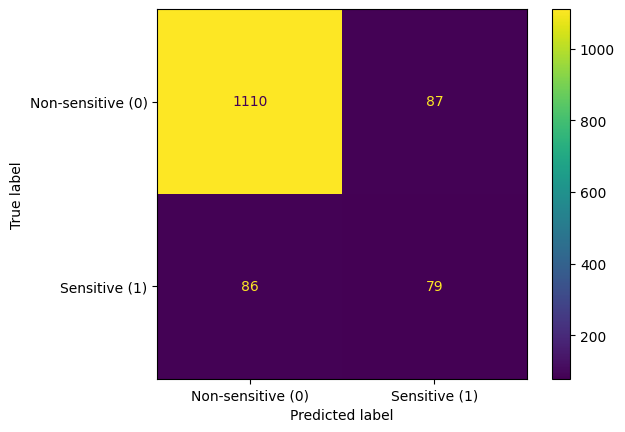

In [31]:
def cat(text):
    l = text.split('\r\n\r\n')
    return l[1]

def svmatch(data):
    np.random.seed(1)
    #print(data.head())

    #data['text'] = data['text'].apply(cat)
    #data = data[data.text.str.len() < 11000]
    
    X = data.text.to_numpy()
    y = data.sensitivity.to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

    majority_class_index = np.where(y_train == 0)[0]
    minority_class_index = np.where(y_train == 1)[0]
    downsampled_majority_index = np.random.choice(majority_class_index, size=len(minority_class_index), replace=False)
    combined_indices = np.concatenate([downsampled_majority_index, minority_class_index])
    X_train = X_train[combined_indices]
    y_train = y_train[combined_indices]

    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(X_train)
    test_tfidf = tfidf_vectoizer.transform(X_test)

    svm_model = SVC()
    svm_model.fit(train_tfidf, y_train)
    svm_preds = svm_model.predict(test_tfidf)
    #print(svm_preds)
    print(get_metric_dict('SVMMATCH', y_test, svm_preds))
    evaluation_summary('SVM', y_test, svm_preds)
    
mr = main_experiment()
    

## Clean

In [15]:
def proccutit(m):
    def pre_dict(d):
        clean = []
        v = d
        v = v.split('\r\n\r\n')[1]

        multi_split = d.split('\r\n\r\n')
        if len(multi_split) > 2:
            reconnect = multi_split[1:]
            v = '\n\n'.join(reconnect)
        
        cleaned_text = v
        cleaned_text = re.sub(r'=\r\n', '\n', cleaned_text)
        cleaned_text = re.sub(r'\r\n', '\n', cleaned_text)
        cleaned_text = re.sub(r'\n>\n', '\n\n', cleaned_text)
        # Or replace with ''
        # Put space in #cleaned_text = re.sub(r'\n> ', '\n', cleaned_text)
        cleaned_text = re.sub(r'\n> ', '\n ', cleaned_text)                         
        cleaned_text = re.sub(r'\n\s+\n', '\n\n', cleaned_text)
        cleaned_text = re.sub(r'\?{2,}', '', cleaned_text)
        cleaned_text = re.sub(r'\n\?+', '', cleaned_text)
        cleaned_text = re.sub(r' \?+', '', cleaned_text)
        cleaned_text = re.sub(r'\?{2,}', '', cleaned_text)
        cleaned_text = re.sub(r'=20', ' ', cleaned_text)
        cleaned_text = re.sub(r'=09', ' ', cleaned_text)
        #cleaned_text = re.sub(r'=\r\n', '\n', cleaned_text)
        #cleaned_text = re.sub(r'\r\n', '\n', cleaned_text)
        # These last two to solve \n with no space and future joining of paragraphs. Second regex for when space exists after newline.
        #cleaned_text = re.sub(r'\n', ' ', cleaned_text)
        #cleaned_text = re.sub(r'  ', ' ', cleaned_text)
        clean.append(cleaned_text)
    
        cutit = cleaned_text.split('\n\n')
        key_sep = []
        sep = []
        keywords = {'To:', 'cc:', 'Sent:', 'From:', 'mailto'}
        for cut in cutit:
            if not any(keyword in cut for keyword in keywords):
                sep.append(cut)
            else:
                key_sep.append(sep)
                sep = []
        key_sep.append(sep)

        #print(len(key_sep))
        paras = []
        for k in key_sep:
            if len(k) == 1:
                para = k[0]
                full_m = ' '.join(para.split('\n'))
                full_m = re.sub(r'  ', ' ', full_m)
                if len(full_m) < 15:
                    continue
                paras.append(full_m)

            else:
                #print(k)
                #print(len(k))
                connected_m = []
                for i, para in enumerate(k):
                    message = ' '.join(para.split('\n'))
                    connected_m.append(message)
                
                full_m = '\n'.join(connected_m)
                full_m = re.sub(r'  ', ' ', full_m)
                if len(full_m) < 15:
                    continue

                paras.append(full_m)

        #print(paras)
        return paras
        
        

    def cutit(m):
        pre = pre_dict(m)
        return pre

    return cutit(m)

def post_process_split_docs(test_array, pre):
    clean_doc_id = {}
    ite = -1
    for i, s in enumerate(test_array):
        if '_' in s:
            s = s[:s.find('_')]

        val = clean_doc_id.get(s, -1)
        #ite += 1

        if val == -1:
            clean_doc_id[s] = pre[i]
            continue

        if (val == pre[i] or val == 1):
            continue
        
        clean_doc_id[s] = pre[i]

    values_array = np.array(list(clean_doc_id.values()))
    return values_array

In [25]:
def svmatch(data):
    #print(data.head())

    X = data.doc_id.to_numpy()
    y = data.sensitivity.to_numpy()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    majority_class_index = np.where(y_train == 0)[0]
    minority_class_index = np.where(y_train == 1)[0]
    np.random.seed(1)
    downsampled_majority_index = np.random.choice(majority_class_index, size=len(minority_class_index), replace=False)

    combined_indices = np.concatenate([downsampled_majority_index, minority_class_index])

    X_train = X_train[combined_indices]
    y_train = y_train[combined_indices]

    X_train = X_train.tolist()
    sep_id = []
    sep_tex = []
    sep_sens = []
    for idd in X_train:
        text = data[data.doc_id == idd].text.item()
        g = proccutit(text)
        for i, m in enumerate(g):
            id_part = idd + '_' + str(i)
            sep_id.append(id_part)
            sep_tex.append(m)
            sep_sens.append(data[data.doc_id == idd].sensitivity.item())

    X_train = sep_tex
    y_train = sep_sens

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    tfidf_vectoizer = TfidfVectorizer()
    train_tfidf = tfidf_vectoizer.fit_transform(X_train)
    test_tfidf = tfidf_vectoizer.transform(X_test)

    svm_model = SVC()
    svm_model.fit(train_tfidf, y_train)
    svm_preds = svm_model.predict(test_tfidf)
    print(svm_preds)
    print(y_test)
    print(get_metric_dict('SVMMATCH', y_test, svm_preds))

In [26]:
def main_experiment():
    sara_dataset = get_sara()
    sara_df = dataset_to_df(sara_dataset)
    train = sara_df
    #print(train.head())
    
    X = train.doc_id.to_numpy()

    '''
    for idd in X:
        print(idd)
        text = train[train.doc_id == idd].text.item()
        #print(text)
        #print(text)
        x = proccutit(text)
        print(x)
        print(len(x))
        return

    '''
   
    svmatch(train)


main_experiment()

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 

/scratch/2469038g/miniconda3/envs/ryanenv2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Note with a smaller test set (e.g., train/test 70/30) the model would likely classify everything as non-sensitive, giving 0.5 BAC.